# Student Segmentation
Segmenting the student population using K-means clustering using thier based on their demographics, study habits, and extracurricular activities. This aims to group similar students together in order to facilitate personalized learning strategies.

As someone who has worked in the education space, we know that this is not generally a good idea as it can limit social mixing and will be of detriment to students who may not already be motivated or are currently struggling. Moreso, many of these predictors are not within direct control of the student and there is a potential for discrimination within a number of these predictors. That is to say, it has the potential to exacerbate existing social strata. However, as a data project it is an interesting exercise and would be applicable in a more perfect world.

In [140]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, confusion_matrix
from kneed import KneeLocator
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import linear_sum_assignment

# import dataset
dataset = pd.read_csv("Student_performance_data.csv")
df = dataset
# Display dataset head
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


## Data Cleaning & Preprocessing

In [141]:
# drop columns
df = df.drop(columns=["StudentID", "GradeClass", "GPA"])

In [142]:
# identify feature types
categorical_features = ["Gender", "Ethnicity", "ParentalEducation", "Tutoring", "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"]
continuous_features = ["Age", "StudyTimeWeekly", "Absences"]

# encode categorical variables
df_encoded = df.copy()
for col in categorical_features:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

# standardize features
scaler = StandardScaler()
df_encoded[df_encoded.columns] = scaler.fit_transform(df_encoded.drop(columns=["Cluster"], errors="ignore"))

# K-Means Clustering
## Determine the Number of Clusters (K)

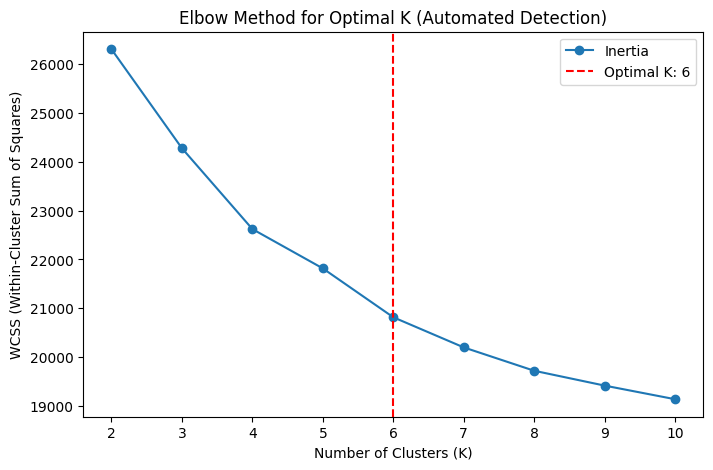

Optimal number of clusters: 6


In [143]:
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_encoded)
    wcss.append(kmeans.inertia_)

# use KneeLocator to find optimal K
knee_locator = KneeLocator(K_range, wcss, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

# plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='-', label="Inertia")
plt.axvline(x=optimal_k, linestyle="--", color="red", label=f"Optimal K: {optimal_k}")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K (Automated Detection)")
plt.legend()
plt.show()

print(f"Optimal number of clusters: {optimal_k}")

## Train Model

In [144]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded["Cluster"] = kmeans.fit_predict(df_encoded)

## Evaluate Clusters
Silhouette Score: how well each student fits into thier cluster (higher scores indicate better-defined clusters)

In [145]:
# print cluster centers
print("Cluster Centers:\n", pd.DataFrame(kmeans.cluster_centers_, columns=df_encoded.columns[:-1]))

# silhouette score
silhouette_avg = silhouette_score(df_encoded.drop(columns=["Cluster"]), df_encoded["Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Cluster Centers:
         Age    Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0 -0.073063 -0.025947  -0.156694          -0.069753         0.038938   
1  0.033597  0.057558  -0.040059           0.064491         0.000558   
2  0.016850 -0.090083  -0.252364          -0.031945         0.086099   
3 -0.026364  0.051444   1.572816           0.107399         0.046428   
4  0.030273 -0.000463   0.031185           0.027693        -0.038446   
5  0.022962  0.007892  -0.540025          -0.042525        -0.083973   

   Absences  Tutoring  ParentalSupport  Extracurricular    Sports     Music  \
0  0.064100  0.075648        -0.022658        -0.015036  1.514848 -0.495161   
1  0.006742 -0.021490         0.080353        -0.025745 -0.059370  2.019544   
2  0.032529  1.522371        -0.009151         0.041887 -0.660132 -0.495161   
3 -0.055719 -0.413888         0.034033        -0.079007 -0.440360 -0.495161   
4 -0.042902 -0.117856        -0.013977        -0.017197 -0.006481  0.039882   
5 -

## Visualize Clusters using a 2-D PCA Projection

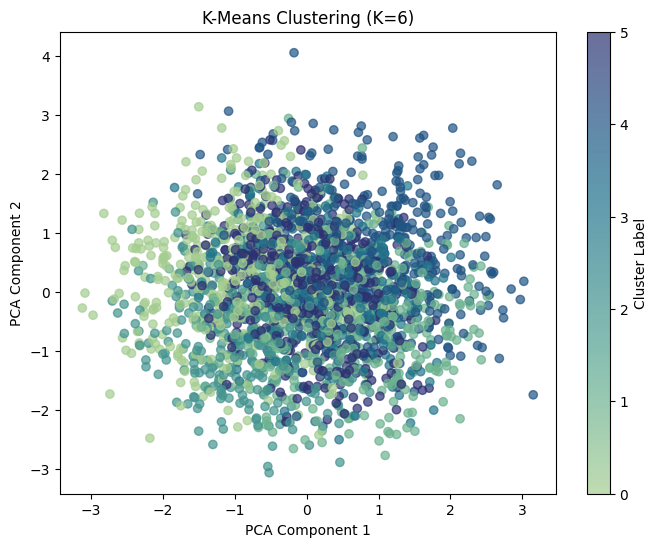

In [146]:
# reduce dataset to 2-D using PCA
pca = PCA(n_components=2)
df_encoded["PCA1"], df_encoded["PCA2"] = pca.fit_transform(df_encoded.drop(columns=["Cluster"])).T

# plot
plt.figure(figsize=(8,6))
plt.scatter(df_encoded["PCA1"], df_encoded["PCA2"], c=df_encoded["Cluster"], cmap="crest", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k})")
plt.colorbar(label="Cluster Label")
plt.show()

As is evident in the silhouette score and the PCA, clusters are not well defined. This means cluster we need to reassess K and compare possible silhouette scores.

C:\Users\Kath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


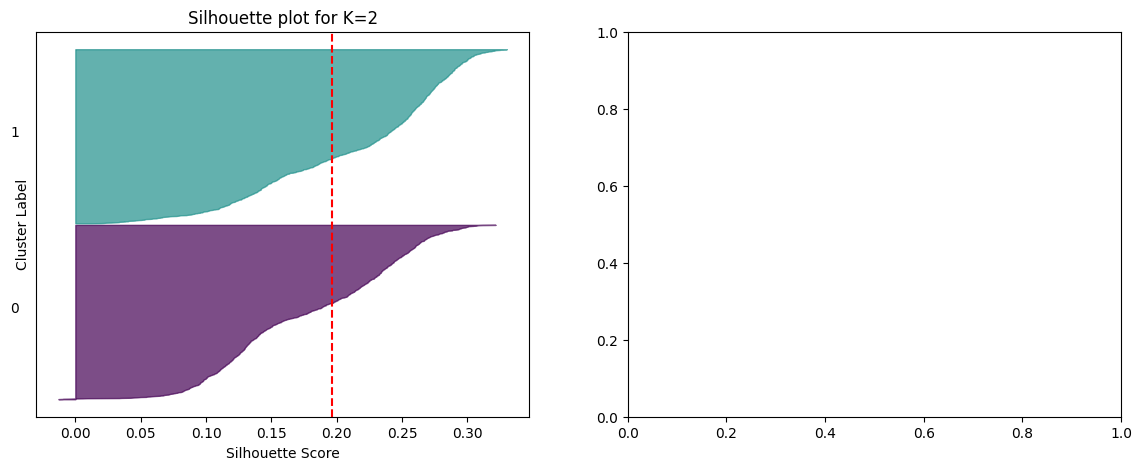

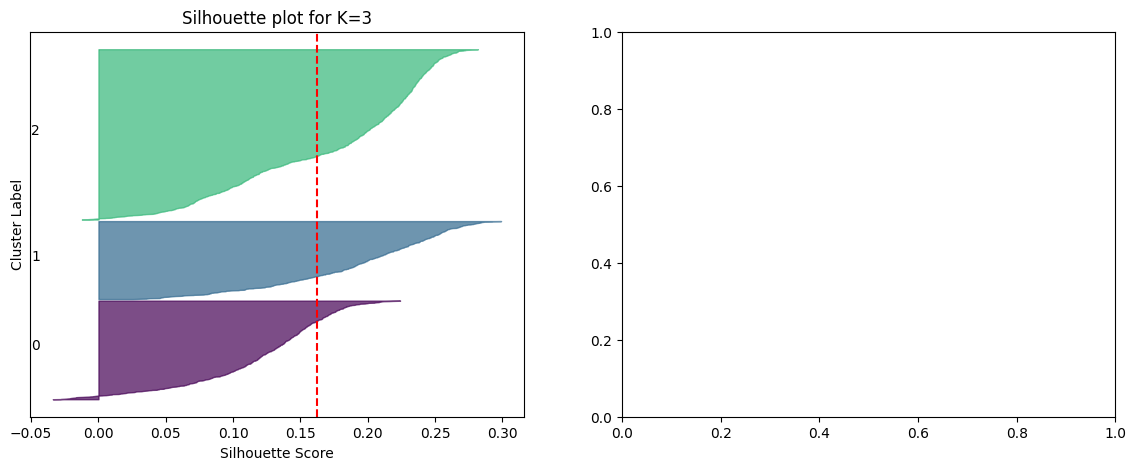

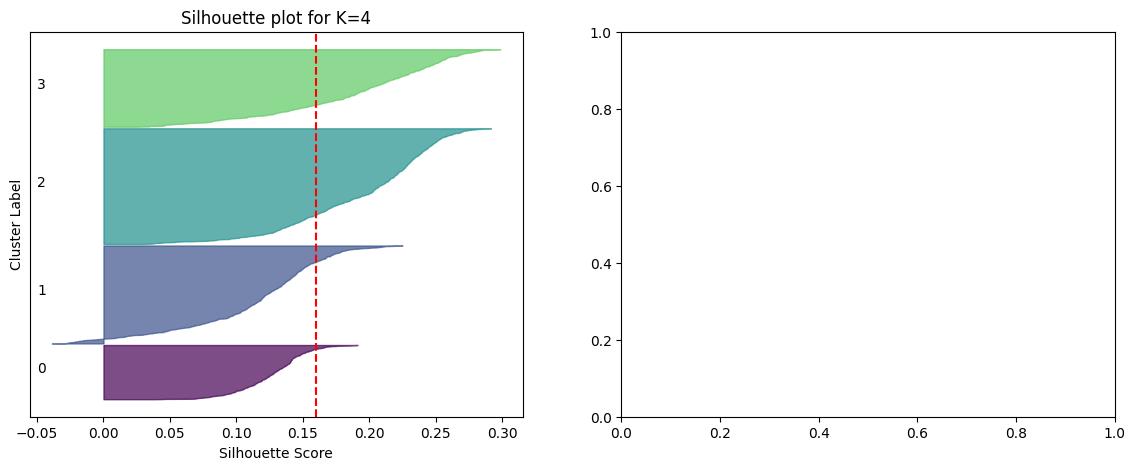

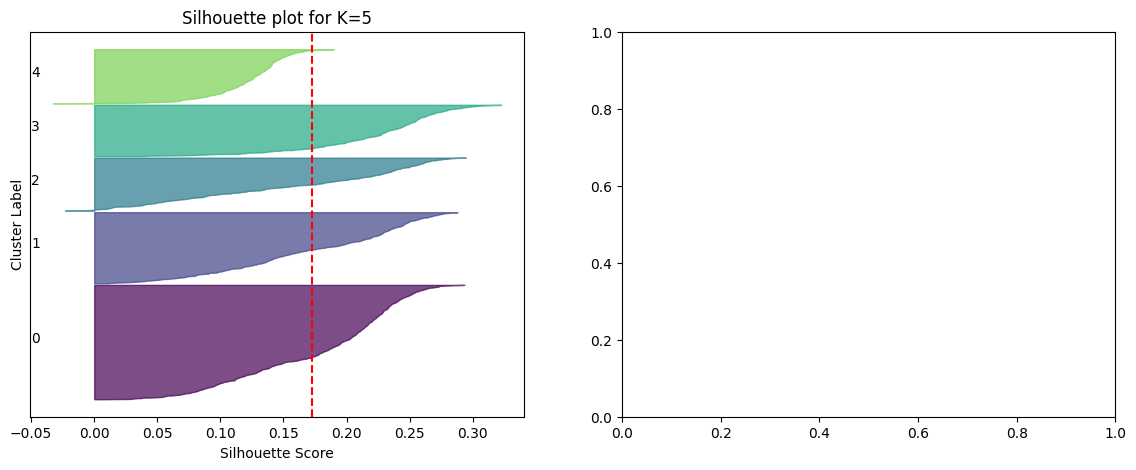

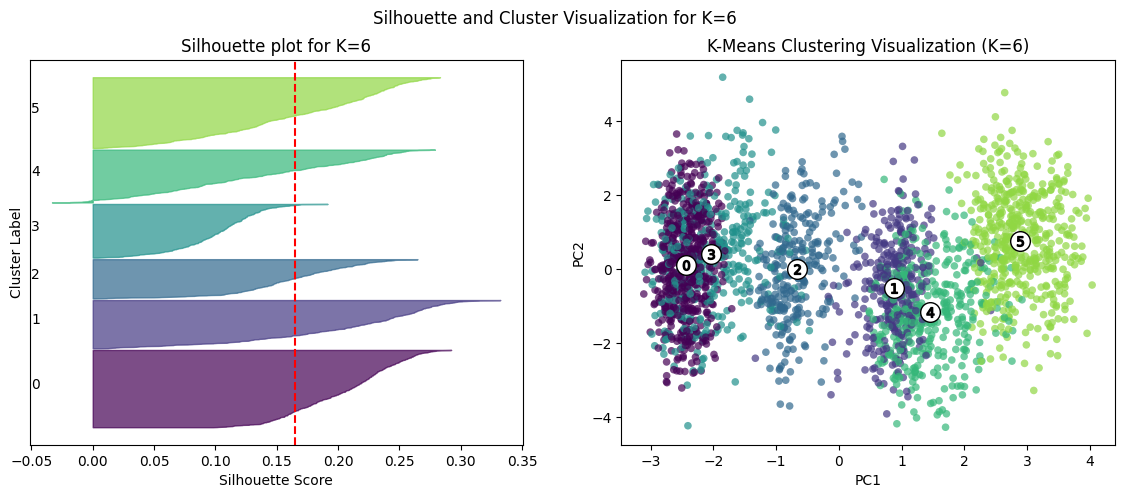

Optimal number of clusters: 2
Silhouette Score: 0.1965


In [147]:
# define range of n clusters to evaluate (2-6)
k_values = range(2, 7)
silhouette_scores = []

# reduce dataset to 2-D for PCA
df_pca = pca.fit_transform(df_encoded)

# loop through K values to generate both plots
for k in k_values:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_encoded)

    # silhouette score
    score = silhouette_score(df_encoded, cluster_labels)
    silhouette_scores.append(score)

    # compute silhouette values for each point
    silhouette_values = silhouette_samples(df_encoded, cluster_labels)

    # silhouette plot setup
    y_lower = 10
    for i in range(k):
        # Aggregate silhouette scores for each cluster
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label silhouette plots with cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # Add space between clusters

    ax1.set_title(f"Silhouette plot for K={k}")
    ax1.set_xlabel("Silhouette Score")
    ax1.set_ylabel("Cluster Label")
    ax1.axvline(x=score, color="red", linestyle="--")  # Average silhouette score line
    ax1.set_yticks([])


# cluster visualization
colors = cm.viridis(cluster_labels.astype(float) / k)
ax2.scatter(df_pca[:, 0], df_pca[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the cluster centers
centers = pca.transform(kmeans.cluster_centers_)  # Transform cluster centers using PCA
ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

ax2.set_title(f"K-Means Clustering Visualization (K={k})")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.suptitle(f"Silhouette and Cluster Visualization for K={k}")

plt.show()

# find optimal K using highest silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)
print(f"Optimal number of clusters: {best_k}\nSilhouette Score: {best_silhouette:.4f}")

## Reevaluating the Model
Now that there is a new K, the a new model will be created. It doesn't need to be evaluated as the silouitte score has already been determined ()

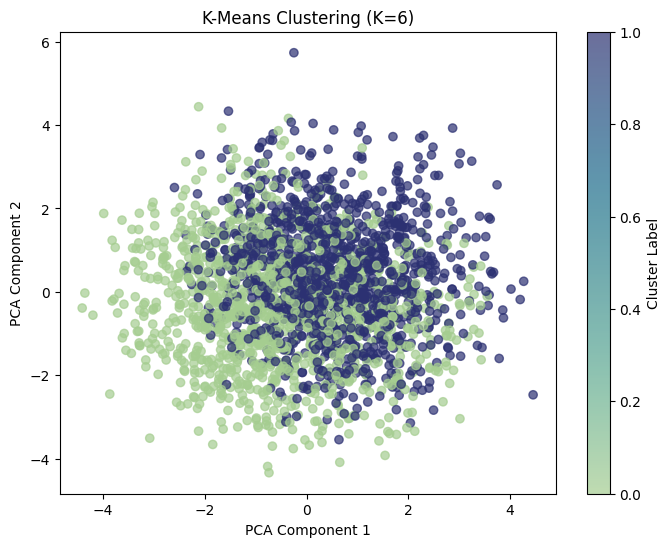

In [148]:
# train model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_encoded["Cluster"] = kmeans.fit_predict(df_encoded)
labels_kmeans = kmeans.fit_predict(df_encoded)
# reduce dataset to 2-D using PCA
pca = PCA(n_components=2)
df_encoded["PCA1"], df_encoded["PCA2"] = pca.fit_transform(df_encoded.drop(columns=["Cluster"])).T

# plot
plt.figure(figsize=(8,6))
plt.scatter(df_encoded["PCA1"], df_encoded["PCA2"], c=df_encoded["Cluster"], cmap="crest", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k})")
plt.colorbar(label="Cluster Label")
plt.show()

# Hierarchical Clustering
Hierarchical clustering is another great method for clustering, creating a chart that resembles that of evolutionary lineage. Preprocessing has already been completed, so the model can be created.

## Perform Clustering

In [149]:
# do the clustering
hc = AgglomerativeClustering(n_clusters=best_k, metric="euclidean", linkage="ward")
labels_hc = hc.fit_predict(df_encoded)

# compute silhouette score
silhouette_hc = silhouette_score(df_encoded, labels_hc)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hc:.4f}")

Silhouette Score for Hierarchical Clustering: 0.0896


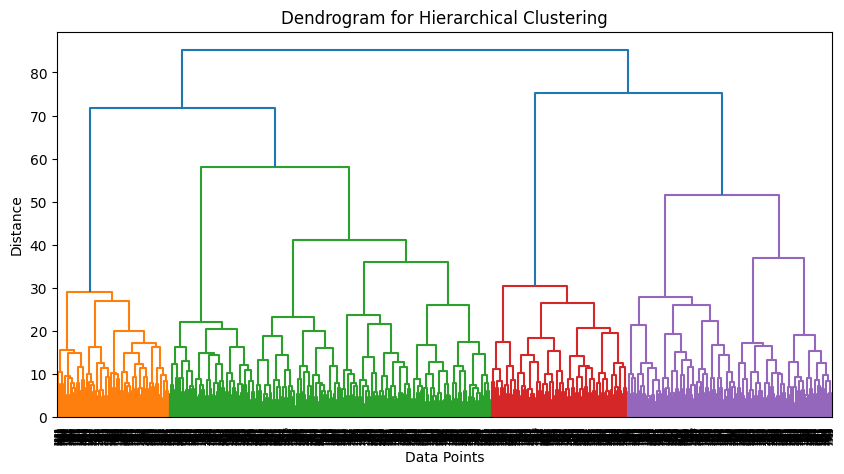

In [150]:
# make dendrogram
plt.figure(figsize=(10, 5))
Z = linkage(df_encoded, method="ward")
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Comparing Models

Silhouette Score for K-Means Clustering: 0.1965
Silhouette Score for Hierarchical Clustering: 0.0896
Cluster Distribution:Cluster
0    1197
1    1195
Name: count, dtype: int64


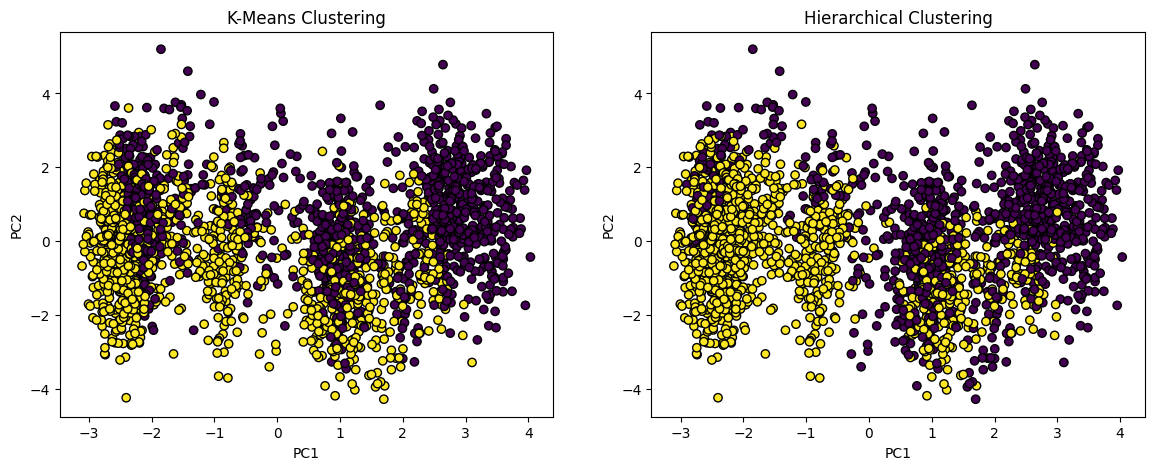

In [151]:
# restating silhouette scores
print(f"Silhouette Score for K-Means Clustering: {best_silhouette:.4f}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hc:.4f}")

# cluster distribution
cluster_counts = df_encoded["Cluster"].value_counts()
print(f"Cluster Distribution:{cluster_counts}")

# plotting it
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-means plot
axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_kmeans, cmap="viridis", marker="o", edgecolor="k")
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# hierarchical clustering plot
axes[1].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_hc, cmap="viridis", marker="o", edgecolor="k")
axes[1].set_title("Hierarchical Clustering")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.show()

Given it has a higher silhouette score, it can be determined that K-means clustering did a better job at segmenting students.

## Evaluating Against True Grade Class Levels
Using confusion matrices, label correction, and the Adjusted Rand Index (ARI), the clustering will be compared to actual student performance.

In [152]:
# define true labels (gradeclass)
y_true = dataset["GradeClass"].values

# function to match cluster labels with true labels using Hungarian Algorithm
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)  # Negative for maximization
    label_mapping = {old: new for old, new in zip(col_ind, row_ind)}
    new_y_pred = np.array([label_mapping[label] for label in y_pred])
    return new_y_pred

# remap K-means and hierarchical labels
labels_kmeans = match_labels(y_true, labels_kmeans)
labels_hc = match_labels(y_true, labels_hc)

# compute ARI
ari_kmeans = adjusted_rand_score(y_true, labels_kmeans)
ari_hc = adjusted_rand_score(y_true, labels_hc)

print(f"K-Means ARI after label correction: {ari_kmeans:.4f}")
print(f"Hierarchical Clustering ARI after label correction: {ari_hc:.4f}")

K-Means ARI after label correction: -0.0005
Hierarchical Clustering ARI after label correction: -0.0027


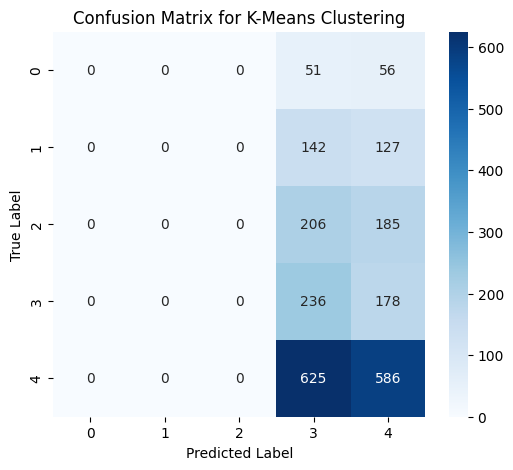

In [153]:
# confusion matrix for K-means
cm_kmeans = confusion_matrix(y_true, labels_kmeans)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix for K-Means Clustering")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

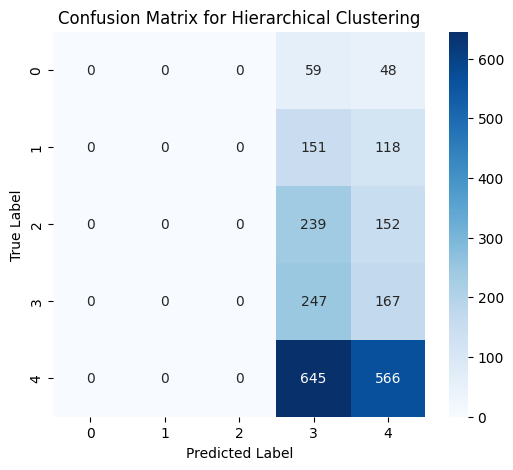

In [154]:
# confusion matrix for hierarchical clustering
cm_hc = confusion_matrix(y_true, labels_hc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_hc, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix for Hierarchical Clustering")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [155]:
# add cluster labels back to original data
dataset["Cluster"] = df_encoded["Cluster"]
print(dataset.groupby("Cluster")["GradeClass"].value_counts(normalize=True) * 100)

# average GPA within each cluster
cluster_avg_gpa = dataset.groupby("Cluster")["GPA"].mean()
print(f"Average GPA per Cluster: {cluster_avg_gpa}")

Cluster  GradeClass
0        4.0           49.122807
         3.0           17.710944
         2.0           15.204678
         1.0           12.949039
         0.0            5.012531
1        4.0           52.133891
         2.0           17.489540
         3.0           16.903766
         1.0            9.539749
         0.0            3.933054
Name: proportion, dtype: float64
Average GPA per Cluster: Cluster
0    1.989309
1    1.822925
Name: GPA, dtype: float64
